# Battery Charge Time
## NVDC Notebook Architecture
#### For the duration of the charging period, the instantaneous battery current will depend on the state of the whole system, which consists of:


*   Adaptor power rating - minus efficiency losses in the charger power train.
*   Charger max current - a new control loop which will protect the charger and inductor. 
*   System load - adds to charger load and can reduce available charging current. If Psys > Padaptor, then Ibattery will be < 0
*   Battery voltage - directly impacts System Voltage in the NVDC architecture. Also, for LiPO batteries, Vbat is current dependent. 
*   Battery current - raises System Voltage through the voltage drop across battery charge path resistence

In [1]:
import scripts.batterycharger as bc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
plt.style.use('seaborn')
from IPython.display import Image

from bokeh.plotting import figure
from bokeh.io import show, output_notebook, output_file

from bokeh.models import ColumnDataSource, Panel
from bokeh.models.widgets import Slider, Tabs, RadioButtonGroup, PreText

from bokeh.layouts import column, row, WidgetBox, gridplot
from bokeh.palettes import Category20_16

from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application

%config IPCompleter.greedy=True

# Set to output the plot in the notebook
output_notebook()


Loading BokehJS ...

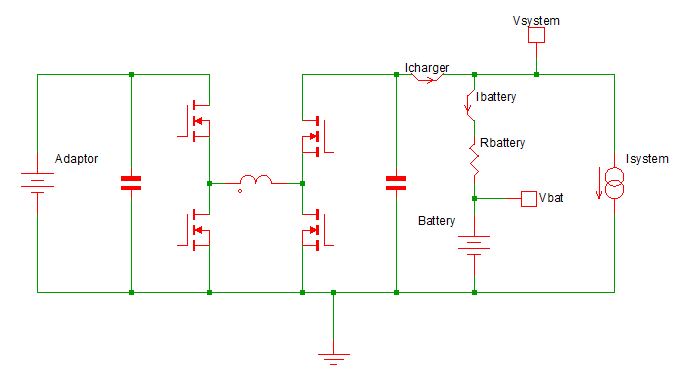

In [2]:
Image('static/charger.png', width=800)

### Functions

In [7]:


def modify_doc(doc):
    
    def make_dataset(padaptor=45,psystem=0,ichargermax=7, soc=0.01, Whr=60,ns=3):
        data=bc.batterystate_vs_t(bc.Charger(bc.Adapter(power=padaptor), bc.Battery(soc=soc,Whr=Whr,nstack=ns),
                                             psystem=psystem, imax=ichargermax))
        chargetime = str(data[0][-1])+'hrs'
        df=pd.DataFrame(np.array(data[1:]).T,index=data[0],columns=['SOC','pout','vbat','vsys','iout','icharge'])
        df.index.name='time(hr)'
        return ColumnDataSource(df)
    
    def make_plot(src,yaxis,plotnum):
        p = figure(plot_height = 200, plot_width = 200, 
                   title = yaxis,
                   x_axis_label = 'time (hr)')
        p.line(x='time(hr)', y=yaxis, source=src, line_width=2, color=Category20_16[plotnum*2])
        return p
    
    def update(attr, old, new):
        new_src = make_dataset(padaptor=adaptoroptions[padaptor_select.active],
                               Whr=batteryoptions[ebattery_select.active],
                               ns=stackoptions[stack_select.active],
                               psystem=psystem_select.value,
                               ichargermax=imax_select.value)
        src.data.update(new_src.data)
        
# create input control widgets        
    adaptoroptions=[45,65,90]
    adaptorselecttitle = PreText(text="Padaptor(W)")
    
    batteryoptions=[52,60,68]
    batteryselecttitle = PreText(text="Battery Capacity(Whr)")
    
    stackoptions=[2,3,4]
    stackselecttitle = PreText(text="Battery Stack(#S)")
    
    padaptor_select = RadioButtonGroup(name="Padaptor", labels=[str(element) for element in adaptoroptions], active=0)
    padaptor_select.on_change('active', update)
    
    ebattery_select = RadioButtonGroup(name="Ebattery", labels=[str(element) for element in batteryoptions], active=0)
    ebattery_select.on_change('active', update)
    
    stack_select = RadioButtonGroup(name="nstack", labels=[str(element) for element in stackoptions], active=0)
    stack_select.on_change('active', update)
    
    psystem_select = Slider(start=0, end=60, value=0, step=5, title="Psystem")
    psystem_select.on_change('value', update)
    
    imax_select = Slider(start=5, end=12, value=5, step=0.5, title="Max Total Current")
    imax_select.on_change('value', update)

# calculate the state of the system
    src = make_dataset(padaptor=adaptoroptions[padaptor_select.active],
                       Whr=batteryoptions[ebattery_select.active],
                       ns=stackoptions[stack_select.active],
                       psystem=psystem_select.value,
                       ichargermax=imax_select.value)
    
# create grid of plots
    plot_names = ['SOC','pout','vbat','vsys','iout','icharge']    
    plot_figs = {}
    for plot_num, plot_yaxis in enumerate(plot_names):
        plot_figs[plot_yaxis] = make_plot(src,plot_yaxis,plot_num)
    
    grid = gridplot([[plot_figs['pout'], plot_figs['vsys'], plot_figs['iout']],
                     [plot_figs['SOC'],  plot_figs['vbat'], plot_figs['icharge']]])
    
# Link together the x-axes for panning and zooming
    plot_figs['SOC'].x_range = \
    plot_figs['vbat'].x_range = \
    plot_figs['icharge'].x_range = \
    plot_figs['pout'].x_range = \
    plot_figs['vsys'].x_range = \
    plot_figs['iout'].x_range

# set up the display panel
    controls = WidgetBox(adaptorselecttitle,
                         padaptor_select,
                         psystem_select,
                         imax_select,
                         batteryselecttitle,
                         ebattery_select,
                         stackselecttitle,
                         stack_select)
    layout = row(controls,grid)
    tab = Panel(child=layout, title = "Charger State vs. Time")
    tabs =Tabs(tabs=[tab])
    
    doc.add_root(tabs)

# Set up an application
handler = FunctionHandler(modify_doc)
app = Application(handler)

In [8]:
# The figure will be rendered in a static HTML file called output_file_test.html
#output_file('output_file_test.html', 
#            title='Battery Charger')

# Show the plot
show(app)

In [9]:
3130/3373

0.9279573080343908